[View in Colaboratory](https://colab.research.google.com/github/NehaAgg245/ML-git/blob/master/Campus_load.ipynb)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving L1_Campus_load_2014-2015_v3.csv to L1_Campus_load_2014-2015_v3.csv


In [0]:
import pandas as pd 
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from pandas import concat
from itertools import islice
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import io

# Import data
campus_data = pd.read_csv(io.StringIO(uploaded['L1_Campus_load_2014-2015_v3.csv'].decode('utf-8')))
campus_data['Timestamp'] = pd.to_datetime(campus_data['Timestamp'])
campus_data.set_index('Timestamp', inplace = True)

utd = campus_data.iloc[:, -1:]



In [0]:
def outliers_iqr(utd):
	utd_updated = pd.DataFrame(columns = ['Total'])
	for year in np.array_split(utd,2):
		quartile_1, quartile_3 = np.percentile(year,[25,75])
		iqr = quartile_3 - quartile_1
		lower_bound = quartile_1 - (iqr * 1.5)
		upper_bound = quartile_3 + (iqr * 1.5)
		for i in year.index:
			if year.at[i,'Total'] < lower_bound:
				low_val = year.at[i,'Total']
				year['Total'].replace(low_val,lower_bound,inplace = True)
			elif year.at[i,'Total'] > upper_bound:
				up_val = year.at[i,'Total']
				year['Total'].replace(up_val,upper_bound,inplace = True)
		utd_updated = utd_updated.append(year)
	return utd_updated

utd = outliers_iqr(utd)

#last time step (t-1) as the input and the observation at the current time step (t) as the output
def timeseries_to_supervised(data, lag = 1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis = 1)
	df.fillna(0,inplace = True)
	return df

#Calculating difference time series to get a stationarity in data
def difference(dataset, interval = 1):
	diff = list()
	for index, row in islice(dataset.iterrows(), interval, None):
		i = dataset.index.get_loc(index)
		i = i-interval
		value = dataset.at[index, 'Total'] - dataset.iloc[i, dataset.columns.get_loc('Total')]
		diff.append(value)
	return Series(diff)

#Invert differenced value to get back into the original scale
def inverse_difference(history, yhat, interval = 1):
	return yhat + history[-interval]

differenced = difference(utd, 1)

# inverted = list()
# for i in range(len(differenced)):
# 	value = inverse_difference(utd, differenced[i], len(utd) - i)
# 	inverted.append(value)
# inverted = Series(inverted)

#Transform scale 
def scale(train, test):
	scaler = MinMaxScaler(feature_range = (-1,1))
	scaler = scaler.fit(train)
	train = train.reshape(train.shape[0], test.shape[1])
	train_scaled = scaler.transform(train)
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

#inverting scaling for a transform value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler. inverse_transform(array)
	return inverted[0,-1]

#fit an lstm network tp training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful = True))
	model.add(Dense(1))
	model.compile(loss = 'mean_squared_error', optimizer = 'adam')
	for i in range(nb_epoch):
		model.fit(X, y , epochs = 1, batch_size= batch_size, verbose = 0, shuffle = False)
		model.reset_states()
	return model

#make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X= X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size = batch_size)
	return yhat[0,0]


supervised = timeseries_to_supervised(differenced, 1)
supervised_values = supervised.values
train, test = supervised_values[0:-8759],supervised_values[-8760:]

scaler, train_scaled, test_scaled = scale(train, test)

In [17]:
repeats = 20
error_scores = list()
for r in range(repeats):
	lstm_model = fit_lstm(train_scaled, 1, 10, 4)
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	predictions = list()
	for i in range(len(test_scaled)):
		X, y = test_scaled[i, 0:-1], test_scaled[i,-1]
		yhat = forecast_lstm(lstm_model, 1, X)
		yhat = invert_scale(scaler, X, yhat)
		yhat = inverse_difference(utd.values, yhat, len(test_scaled)+1 - i)
		predictions.append(yhat)
	rmse = sqrt(mean_squared_error(utd.values[-8760:],predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)


1) Test RMSE: 88.316
2) Test RMSE: 95.499
3) Test RMSE: 95.441
4) Test RMSE: 97.793
5) Test RMSE: 92.229
6) Test RMSE: 103.028
7) Test RMSE: 90.136
8) Test RMSE: 91.050
9) Test RMSE: 93.791
10) Test RMSE: 107.242
11) Test RMSE: 89.189
12) Test RMSE: 89.769
13) Test RMSE: 97.383
14) Test RMSE: 98.786
15) Test RMSE: 92.044
16) Test RMSE: 89.587
17) Test RMSE: 89.982
18) Test RMSE: 88.912
19) Test RMSE: 92.541
20) Test RMSE: 94.328


             rmse
count   20.000000
mean    93.852352
std      5.011660
min     88.316151
25%     89.929060
50%     92.385111
75%     95.970337
max    107.242497


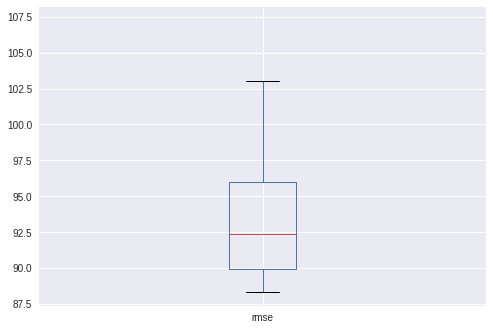

In [19]:
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()